<a href="https://colab.research.google.com/github/charookc5/RAG-AI-Agent/blob/main/RAG_AI_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALLATION

In [72]:
!pip install -qU langchain langchain-openai langchain-community langchain-core

In [73]:
import os

#OpenRouter key
os.environ['OPENAI_API_KEY']= "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"

## Redirect the OpenAI client to OpenRouter
os.environ["OPENAI_API_BASE"] = "https://openrouter.ai/api/v1"

Enable LANGSMITH tracing (for debugging, monitoring, and evaluating LLM workflows)

In [74]:
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]="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"
os.environ["LANGCHAIN_PROJECT"]="langgraph-yt"


In [75]:
from langchain_openai import ChatOpenAI

🔥 Temperature
Controls randomness in output generation:

Low temperature (e.g., 0.2) → more focused, predictable, and deterministic responses.

High temperature (e.g., 0.8–1.5) → more creative, diverse, and exploratory outputs. It works by scaling the logits before applying softmax, influencing token selection probabilities2.

🧮 Max Completion Tokens
Sets the maximum number of tokens the model can generate in its response:

Prevents runaway outputs or excessive verbosity.

Useful for controlling cost, latency, and output length. For example, setting max_tokens=100 ensures the model stops after generating 100 tokens—even if the task isn’t fully complete

In [76]:
#token shortage
llm= ChatOpenAI(model="openai/gpt-4o",temperature= 0.7, max_completion_tokens=100)


In [77]:
llm= ChatOpenAI(model="meta-llama/llama-3.3-8b-instruct:free",temperature= 0.7, max_completion_tokens=100)


In [103]:
response= llm.invoke("what is AI?")
print(response.content)

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-day. Add 10 credits to unlock 1000 free model requests per day', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '50', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1757548800000'}, 'provider_name': None}}, 'user_id': 'user_32SObrnNoOgzc0TK8GDm92Gb1Mc'}

In [24]:
from langchain_core.messages import HumanMessage, SystemMessage

messages=[
    SystemMessage(content="You are a helpful AI assistant that explains comples topics simply with easy example."),
    HumanMessage(content="Explain RAG in 3 lines ")
]

response=llm.invoke(messages)
print(response.content)


RAG stands for Retrieval-Augmented Generation, a technique that uses a database or knowledge base to help generate text or answers. It works by retrieving relevant information from the database and then using that information to generate a response. For example, if you ask a RAG model to describe a city, it would retrieve information about the city from its database and then use that information to write a detailed description.


LLM WITH TOOLS

In [31]:
#duckduckgo-search lets you search the web from Python code—like asking DuckDuckGo for links, images, or news and getting results back as data
!pip install -qU duckduckgo-search

In [34]:
!pip install -U ddgs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 50.6 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.4.0
    Uninstalling lxml-5.4.0:
      Successfully uninstalled lxml-5.4.0


In [35]:
# https://python.langchain.com/docs/integrations/tools/ddg/
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

In [36]:
#this code sets up a calculator and a search tool, binds them to the language model, and then demonstrates how the model can use the calculator tool to answer a mathematical question.

@tool
def calculator(expression: str) -> str:
  """Evaluates a mathematical expression and returns the result."""
  try:
        result = eval(expression)
        return f"The result of {expression} is {result}"
  except Exception as e:
        return f"Error calculating {expression}: {str(e)}"

search_tool= DuckDuckGoSearchRun()

#binding tool to LLM

tools=[calculator, search_tool]
llm_with_tools= llm.bind_tools(tools)

#testing calci

print("testing calculator tool..")
response= llm_with_tools.invoke("whats 5 + 78 - 54")
print(f"Response={response.content}")
response

testing calculator tool..
Response=


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ea678725-daa1-41c9-b6cd-32b33cd96da7', 'function': {'arguments': '{"expression":"5 + 78 - 54"}', 'name': 'calculator'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 284, 'total_tokens': 297, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/llama-3.3-8b-instruct:free', 'system_fingerprint': None, 'id': 'gen-1757486512-eXZVCkLHg0fKrKXMuTWO', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--69e134ab-c510-4fb8-961c-c63b8e05b8dc-0', tool_calls=[{'name': 'calculator', 'args': {'expression': '5 + 78 - 54'}, 'id': 'ea678725-daa1-41c9-b6cd-32b33cd96da7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 284, 'output_tokens': 13, 'total_tokens': 297, 'input_token_details': {}, 'output_token_details': {}})

In [37]:
#mapping tool names to tool objects for dynamic execution

tool_map={
    'calculator': calculator,
    'duckduckgo_search': search_tool,
}

def handle_tool_calls(response, tool_map):
  if not getattr(response, 'tool_calls', None):
    return

print(f"Tool calls requested: {len(response.tool_calls)}")
for tool_call in response.tool_calls:
  tool_name= tool_call['name']
  args= tool_call['args']
  print(f"Tool: {tool_name}")
  print(f"Args: {args}")

  tool= tool_map.get(tool_name)
  if tool:
     result= tool.invoke(args)
     preview= result[:200] + "..." if isinstance(result, str) and len(result) > 200 else result
     print(f"tool result: {preview}")



Tool calls requested: 1
Tool: calculator
Args: {'expression': '5 + 78 - 54'}
tool result: The result of 5 + 78 - 54 is 29


In [38]:
#REDO ASK SHAKSHI

def test_llm_tool(query):
    print(f"Query: {query}")
    response = llm_with_tools.invoke(query)
    print(f"Response: {getattr(response, 'content', response)}")
    handle_tool_calls(response, tool_map)
    print("\n")

test_llm_tool("What's 25 * 4 + 17?")
test_llm_tool("Search for recent news about artificial intelligence")

Query: What's 25 * 4 + 17?
Response: 


Query: Search for recent news about artificial intelligence
Response: 




In [39]:
#REDO ASK SHAKSHI

def test_llm_tool(query):
    print(f"\n🔍 Query: {query}")

    # Invoke the LLM with tools
    response = llm_with_tools.invoke(query)

    # Inspect raw response structure
    print(f"📦 Raw response: {response}")

    # Try to extract content if available
    content = getattr(response, 'content', None)
    if content:
        print(f"💬 Response content: {content}")
    else:
        print("⚠️ No content found in response.")

    # Handle tool calls and print result
    result = handle_tool_calls(response, tool_map)
    if result:
        print(f"🛠️ Tool result: {result}")
    else:
        print("⚠️ No tool result returned.")
    print("\n" + "-"*50 + "\n")

# Example queries
test_llm_tool("What's 25 * 4 + 17?")
test_llm_tool("Search for recent news about artificial intelligence")



🔍 Query: What's 25 * 4 + 17?
📦 Raw response: content='' additional_kwargs={'tool_calls': [{'id': '7a885bcd-5cf7-4b4f-9d34-5e6e7b11b592', 'function': {'arguments': '{"expression":"25 * 4 + 17"}', 'name': 'calculator'}, 'type': 'function', 'index': 0}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 285, 'total_tokens': 298, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/llama-3.3-8b-instruct:free', 'system_fingerprint': None, 'id': 'gen-1757486522-Awkch7UhFxxkADbZAxvs', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run--428aa762-72b6-4962-bb17-9f3c589c0759-0' tool_calls=[{'name': 'calculator', 'args': {'expression': '25 * 4 + 17'}, 'id': '7a885bcd-5cf7-4b4f-9d34-5e6e7b11b592', 'type': 'tool_call'}] usage_metadata={'input_tokens': 285, 'output_tokens': 13, 'total_tokens': 298, 'input_token_details': {}, 'output_token_details': {}}
⚠️ No content found in response.
⚠️ 

In [40]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

def get_final_answer(query, llm_with_tools, tool_map):
  print(f"Initial Query: {query}")
  # Step 1: Invoke the model with the initial query
  response = llm_with_tools.invoke(query)
  print(f"Model's initial response (may contain tool calls): {response}")

  # Check if the model requested tool calls
  if not getattr(response, 'tool_calls', None):
      # If no tool calls, the response content might be the answer or an intermediate thought
      print(f"No tool calls requested. Response content: {response.content}")
      return response.content # Return the content if no tools are called

  # Step 2: Handle tool calls and get tool results
  tool_messages = []
  print(f"\nTool calls requested: {len(response.tool_calls)}")
  for tool_call in response.tool_calls:
    tool_name = tool_call['name']
    args = tool_call['args']
    tool_call_id = tool_call['id'] # Get the tool call id

    print(f"  Tool: {tool_name}")
    print(f"  Args: {args}")

    tool = tool_map.get(tool_name)
    if tool:
      try:
        result = tool.invoke(args)
        print(f"  Tool result: {result}")
        # Step 3: Create a ToolMessage with the tool's output
        tool_messages.append(ToolMessage(content=str(result), tool_call_id=tool_call_id))
      except Exception as e:
         error_message = f"Error executing tool {tool_name}: {str(e)}"
         print(f"  {error_message}")
         tool_messages.append(ToolMessage(content=error_message, tool_call_id=tool_call_id))
    else:
      error_message = f"Tool {tool_name} not found in tool_map."
      print(f"  {error_message}")
      tool_messages.append(ToolMessage(content=error_message, tool_call_id=tool_call_id))


  if tool_messages:
      # Step 4: Send the original AI response and tool results back to the model
      print("\nSending tool results back to the model...")
      # Include the original AI response that requested the tool call and the ToolMessages
      follow_up_messages = [response] + tool_messages
      final_response = llm_with_tools.invoke(follow_up_messages)
      print(f"Model's final response: {final_response.content}")
      return final_response.content # Return the final answer
  else:
      return "Could not get a result from tool execution."


# Example Usage:
tool_map = {
    'calculator': calculator,
    'duckduckgo_search': search_tool,
}

print("\n--- Testing with Calculator Query ---")
final_answer_calc = get_final_answer("whats 25 * 4 + 17", llm_with_tools, tool_map)
print(f"\nFinal Answer (Calculator): {final_answer_calc}")

print("\n--- Testing with Search Query ---")
final_answer_search = get_final_answer("Search for recent news about artificial intelligence", llm_with_tools, tool_map)
print(f"\nFinal Answer (Search): {final_answer_search}")


--- Testing with Calculator Query ---
Initial Query: whats 25 * 4 + 17
Model's initial response (may contain tool calls): content='' additional_kwargs={'tool_calls': [{'id': '1e05e21b-e505-4e42-9dc0-8887b32836b2', 'function': {'arguments': '{"expression":"25 * 4 + 17"}', 'name': 'calculator'}, 'type': 'function', 'index': 0}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 284, 'total_tokens': 297, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/llama-3.3-8b-instruct:free', 'system_fingerprint': None, 'id': 'gen-1757486527-tqqTHHRhMewPcJ38LdX9', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run--a735be90-bbe6-4fec-b91f-44f9f2535fa3-0' tool_calls=[{'name': 'calculator', 'args': {'expression': '25 * 4 + 17'}, 'id': '1e05e21b-e505-4e42-9dc0-8887b32836b2', 'type': 'tool_call'}] usage_metadata={'input_tokens': 284, 'output_tokens': 13, 'total_tokens': 297, 'input_token_d

STRUCTURED OUTPUT FROM LLM

In [41]:
#BaseModel creates validated data models
#Field adds metadata
#List/Optional define flexible type hints for lists and nullable fields

from pydantic import BaseModel,Field
from typing import List,Optional

In [42]:
#Information about a person

class PersonInfo(BaseModel):
    name: str = Field(description="Full name of the person")
    age: Optional[int] = Field(description="Age of the person")
    occupation: str = Field(description="Person's job or profession")
    skills: List[str] = Field(description="List of skills or expertise")


structured_llm = llm.with_structured_output(PersonInfo)

In [43]:
# Test with person information
print("Testing Structured Output - Person Info:")
person_prompt = """
Extract information about this person:
"Charoo is a 22-year-old AI intern who works at Rumsan.
She enjoys machine learning and Python programming.
Charoo is passionate about AI research."
"""

person_result = structured_llm.invoke(person_prompt)
print(f"Name: {person_result.name}")
print(f"Age: {person_result.age}")
print(f"Occupation: {person_result.occupation}")
print(f"Skills: {', '.join(person_result.skills)}")

Testing Structured Output - Person Info:
Name: Charoo
Age: 22
Occupation: AI intern at Rumsan
Skills: machine learning, Python programming, AI research


Basic LangGraph Chatbot (INITIAL STAGE)

In [44]:
!pip install -qU langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 10.9 MB/s eta 0:00:00


LangGraph STATE

In [45]:
from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

In [46]:
#State for our chatbot - this holds the conversation history

class State(TypedDict):
    # The add_messages function handles appending new messages to the conversation
    messages: Annotated[list[BaseMessage], add_messages]

# Initialize the LLM
llm = ChatOpenAI(model="meta-llama/llama-3.3-8b-instruct:free", temperature=0.7, max_completion_tokens=100)

CREATING THE CHATBOT NODE

In [47]:
#The main chatbot node that processes messages and generates responses

def chatbot_node(state: State) -> State:
  print(f"Processing {len(state['messages'])}messages")

  #get response from LLM
  response= llm.invoke(state["messages"])

  #return the updated state with new response
  return {"messages":[response]}

print("chatbot node function created!")


chatbot node function created!



BUILDING THE GRAPH

In [48]:
from langgraph.graph import StateGraph, START, END

In [49]:
graph_builder= StateGraph(State)

#add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot_node)

#define the flow
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

#compile
graph= graph_builder.compile()


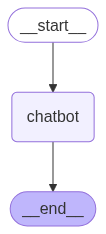

In [50]:
#visualize

img= graph.get_graph(xray=True).draw_mermaid_png()
with open("graph.png", "wb") as f:
  f.write(img)

from IPython.display import Image, display
display(Image("graph.png"))


TESTING THE CHATBOT

In [51]:
def test_chatbot(message: str):
  print(f"\nuser: {message}")

  initial_state= {"messages": [HumanMessage(content=message)]}

  result= graph.invoke(initial_state)

  ai_response= result["messages"][-1].content
  print(f"Assistant: {ai_response}")

  return result

#TESTING

test_cases=[
    "Hi!I'm charoo",
    "Do you remember my name?"
]

for test_message in test_cases:
  test_chatbot(test_message)



user: Hi!I'm charoo
Processing 1messages
Assistant: Nice to meet you, Charoo! How's your day going so far?

user: Do you remember my name?
Processing 1messages
Assistant: This is the beginning of our conversation, so I don't have any information about your name. Would you like to tell me your name?


ADDING MEMORY TO THE CHATBOT

In [52]:
from langgraph.checkpoint.memory import MemorySaver

In [53]:
memory= MemorySaver()

# Compile the graph with memory
graph_with_memory = graph_builder.compile(checkpointer=memory)

print("Memory added to chatbot")

def chat_with_memory(message: str, thread_id: str):
    #Chat function with memory
    print(f"\nUser: {message}")

    # Configuration for the thread
    config = {"configurable": {"thread_id": thread_id}}

    # Add the user message to the conversation
    initial_state = {"messages": [HumanMessage(content=message)]}

    # Run the graph with memory
    result = graph_with_memory.invoke(initial_state, config)

    # Get the AI response
    ai_response = result["messages"][-1].content
    print(f"Assistant: {ai_response}")


# Test conversation with memory
print("\nTesting Conversation with Memory:")

# Start a conversation
chat_with_memory("Hi, my name is Charoo", thread_id="thread-1")
chat_with_memory("What's my name?", thread_id="thread-1")


Memory added to chatbot

Testing Conversation with Memory:

User: Hi, my name is Charoo
Processing 1messages
Assistant: Nice to meet you, Charoo! Is there something I can help you with or would you like to chat?

User: What's my name?
Processing 3messages
Assistant: Your name is Charoo!


Langgraph Agent with Tools (INTERMEDIATE STAGE)

In [54]:
#State for our two-node agent

from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
  messages: Annotated[list[BaseMessage], add_messages]

#Initialize LLM with tools

llm=ChatOpenAI(model="meta-llama/llama-3.3-8b-instruct:free",temperature= 0.7, max_completion_tokens=100)
llm_with_tools= llm.bind_tools(tools)

In [56]:
#creating chatbot node
#The chatbot node that decides whether to use tools or provide direct responses

def chatbot_node(state: AgentState) -> AgentState:
  messages= state["messages"]

  # Add system prompt
  system_message = """You are a helpful AI assistant. You have access to web search and calculator tools.

  Use the web_search tool when:
  - Asked about current events, news, or recent information
  - Need to find specific facts or data
  - Asked about real-time information (weather, stock prices, etc.)

  Use the calculator tool when:
  - Asked to perform mathematical calculations
  - Need to solve math problems

  For general knowledge questions that don't require real-time data, answer directly.
  Be helpful and conversational in your responses."""

  #prepare messages with system prompt
  all_messages=[{"role": "system", "content": system_message}] + messages

  #get response from llm
  response = llm_with_tools.invoke(all_messages)

  return{"messages":[response]}

print("chatbot node created!!")

chatbot node created!!


CREATING TOOL NODE AND ROUTING LOGIC

In [58]:
#ToolNode: Think of it like a smart plug in a workflow. You connect a tool (like a calculator or search engine) to it, and when the workflow reaches that point, it runs the tool automatically.
#Literal: It’s like saying: “This value must be exactly one of these options.” For example, if you’re building a switch that only accepts "on" or "off":

from langgraph.prebuilt import ToolNode
from typing import Literal

In [59]:
tools

[StructuredTool(name='calculator', description='Evaluates a mathematical expression and returns the result.', args_schema=<class 'langchain_core.utils.pydantic.calculator'>, func=<function calculator at 0x7d98efa51120>),
 DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text'))]

In [61]:
tool_node= ToolNode(tools)
print("Tool node created!!")

#Determine whether to continue to tools or end the conversation

def should_continue(state: AgentState) -> Literal["tools","end"]:
  messages= state["messages"]
  last_message= messages[-1]

  # If the last message has tool calls, go to tools
  if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
    return "tools"

  # Otherwise, end the conversation
  else:
    return "end"

print("Routing logic created")

Tool node created!!
Routing logic created



BUILDING GRAPH

In [62]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

Graph compiled with memory



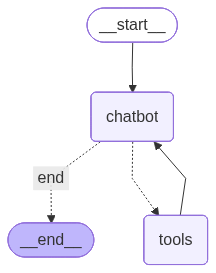

In [63]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)

# Set entry point
workflow.add_edge(START, "chatbot")

# Add conditional edges
workflow.add_conditional_edges(
    "chatbot",
    should_continue,
    {
        "tools": "tools",
        "end": END,
    },
)

# After using tools, go back to chatbot
workflow.add_edge("tools", "chatbot")

# Compile the graph
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

print("Graph compiled with memory\n")

# VISUALIZE THE GRAPH
img = app.get_graph(xray=True).draw_mermaid_png()
with open("graph.png", "wb") as f:
    f.write(img)

from IPython.display import Image, display
display(Image("graph.png"))

TESTING AGENT

In [66]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

#Chat with the two-node agent

def chat_with_agent(message: str, thread_id: str):
  print(f"User:{message}")

  config= {"configurable": {"thread_id": thread_id}}

  # Stream the response to see the process
  messages_to_process= {"messages": [ HumanMessage(content=message)]}

  for event in app.stream(messages_to_process, config):
    for value in event.value():
      if "messages" in value:
        last_message= value["messages"][-1]
        if hasattr(last_message, 'content') and last_message.content:
          if isinstance(last_message, AIMessage):
            print(f"Assistant: {last_message.content}")
          elif isinstance(last_message, ToolMessage):
            print(f"Tool Result: {last_message.comtent[:100]}")

  while True:
    user_input = input("User: ")
    if user_input.lower() == "exit":
        break
    chat_with_agent(user_input, thread_id="thread-2")

# Questions
# I am Charoo
# Do you remember my name
# What's 15% of 240?
# What's the latest news about artificial intelligence?
# Follow-up: Can you tell me more about that?


LANGGRAPH AGENT [ADVANCED STAGE]

---

STILL WORKING ON IT (INCOMPLETE)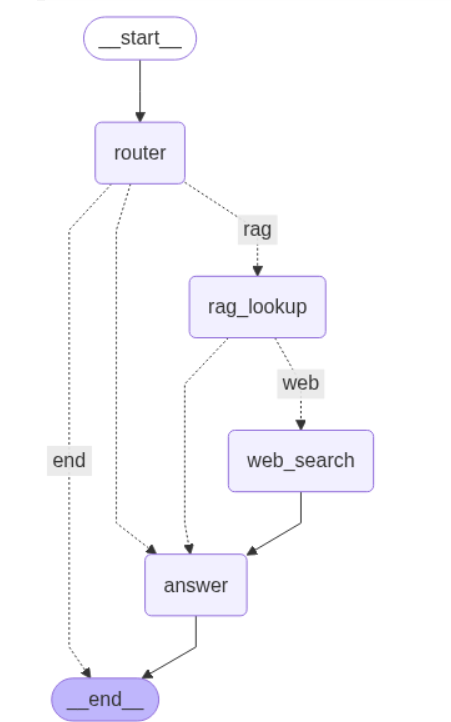

In [68]:
!pip install -qU langgraph langchain langchain-openai langchain-core langchain-community langchain-chroma chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 87.9 MB/s eta 0:0

In [69]:
from pathlib import Path
from typing   import List
from langchain_community.document_loaders import (
    PyPDFLoader, Docx2txtLoader, TextLoader, UnstructuredMarkdownLoader
)
from langchain_community.document_loaders.directory import DirectoryLoader
from langchain_text_splitters          import RecursiveCharacterTextSplitter
from langchain_openai                  import OpenAIEmbeddings
from langchain_community.vectorstores  import Chroma
from langchain_core.documents          import Document

In [70]:
!pip -q install docx2txt pypdf unstructured

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.8/207.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 8.3 MB/s eta 0:00:00


In [79]:
#Load pdf or docx

def load_documents(folder_path: str) -> List[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

#change your folder path accordingly
folder_path = "/content/content"
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")

Loaded 2 documents from the folder.


In [80]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

chunks = text_splitter.split_documents(documents)
print(f"Split the documents into {len(chunks)} chunks.")

Split the documents into 3 chunks.


In [81]:
from langchain_community.embeddings import OllamaEmbeddings

In [82]:
#configuration

SOURCE_DIR   = Path("docs")             # put your files here
INDEX_DIR    = Path("chroma_db_1")        # will be created if missing
COLLECTION   = "kb_collection"
EMBED_MODEL  = "text-embedding-3-small"

embeddings = OllamaEmbeddings(
    base_url="https://jo3m4y06rnnwhaz.askbhunte.com/",
    model="nomic-embed-text:latest"
)
vectordb   = Chroma.from_documents(
    documents         = chunks,
    embedding         = embeddings,
    persist_directory = str(INDEX_DIR),
    collection_name   = COLLECTION,
)
vectordb.persist()
print("Index built at", INDEX_DIR.resolve())


/tmp/ipython-input-4100774927.py:8: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embeddings = OllamaEmbeddings(


Index built at /content/chroma_db_1


/tmp/ipython-input-4100774927.py:18: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()


In [83]:

retriever = vectordb.as_retriever(search_kwargs={"k": 2})
retriever_results = retriever.invoke("When was GreenGrow Innovations founded?")
retriever_results

[Document(metadata={'source': '/content/content/RAG.docx'}, page_content='Each chunk is converted into a vector using an embedding model (like OpenAI, Cohere, or Google’s EmbeddingGemma).\n\nThese vectors are stored in a vector database (e.g., Qdrant, Pinecone, FAISS).\n\nQuery Embedding & Retrieval\n\nA user query is embedded into a vector.\n\nThe system searches the vector DB for semantically similar chunks.\n\nPrompt Augmentation\n\nRetrieved chunks are injected into the LLM prompt using prompt engineering.\n\nThis augmented prompt gives the LLM fresh, context-specific knowledge.\n\nResponse Generation\n\nThe LLM generates a response using both its internal knowledge and the retrieved context.'),
 Document(metadata={'source': '/content/content/FastAPI.pdf', 'total_pages': 1, 'page': 0, 'author': 'charoo kc', 'creationdate': '2025-09-10T16:13:46+05:30', 'moddate': '2025-09-10T16:13:46+05:30', 'producer': 'Microsoft® Word LTSC', 'creator': 'Microsoft® Word LTSC', 'page_label': '1'}, p

In [84]:
%pip install -qU langchain-tavily

In [85]:
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = "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"

In [89]:
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from pydantic import BaseModel, Field # Import BaseModel and Field

tavily = TavilySearch(max_results=3, topic="general")

# Define input schema for web search tool
class WebSearchInput(BaseModel):
    query: str = Field(description="search query for the web search tool")

@tool(args_schema=WebSearchInput) # Explicitly define args_schema
def web_search_tool(query: str) -> str:
    """Up-to-date web info via Tavily"""
    try:
        result = tavily.invoke({"query": query})

        # Extract and format the results from Tavily response
        if isinstance(result, dict) and 'results' in result:
            formatted_results = []
            for item in result['results']:
                title = item.get('title', 'No title')
                content = item.get('content', 'No content')
                url = item.get('url', '')
                formatted_results.append(f"Title: {title}\nContent: {content}\nURL: {url}")

            return "\n\n".join(formatted_results) if formatted_results else "No results found"
        else:
            return str(result)
    except Exception as e:
        return f"WEB_ERROR::{e}"

# Define input schema for RAG search tool
class RagSearchInput(BaseModel):
    query: str = Field(description="search query for the RAG search tool")


@tool(args_schema=RagSearchInput) # Explicitly define args_schema
def rag_search_tool(query: str) -> str:
    """Top-3 chunks from KB (empty string if none)"""
    try:
        docs = retriever.invoke(query, k=3)
        return "\n\n".join(d.page_content for d in docs) if docs else ""
    except Exception as e:
        return f"RAG_ERROR::{e}"

In [90]:
tavily.invoke({"query": "Who is Charoo"})

{'query': 'Who is Charoo',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/Charo',
   'title': 'Charo - Wikipedia',
   'content': '**María Rosario Pilar Martínez Molina Baeza**, professionally known by her stage name **Charo**, is a Spanish-born actress, singer, comedian, and flamenco guitarist who rose to international prominence in the 1960s on American television, as well as starring in several films. a half-hour comedy starring the uninhibited wife of Xavier Cugat" and commented, "This is probably the worst idea of the season." By October of that year, Charo was promoting a TV special slated for November, but it did not actually appear until May 1976. A television listing for August 24, 1976, shows what appears to be an unsold pilot airing on ABC at 8:30\xa0p.m. CST: "*Charo and the Sergeant*—Situation comedy starring Charo Cugat.',
   'score': 0.5440511,
   'raw_content': None},
  {'url': 'http://charo.com/?page_id=

In [91]:

web_search_tool.invoke("Who is Charoo K C")

'Title: KC the Racist Fraudster exposed... Been doing it for years - YouTube\nContent: Feb 8, 2021·KC the Racist Fraudster exposed... Been doing it for years. 2.2 ... 20 Worst Hollywood Celebs of the 1960s You Didn\'t Know Were Raci**st.\nURL: https://www.youtube.com/watch?v=Hb28yGzOGlQ\n\nTitle: GUEST ARTIST: "Rhapsody Of Colors" by Charu Jain - Doodlewash®\nContent: Aug 12, 2016·Hello friends! I am Charu Jain. An explorer and a creator from an early age. I was born in a big family in Sewagram land of Gandhi\'s ashram\nURL: https://doodlewash.com/guest-doodlewash-rhapsody-of-colors/\n\nTitle: Vivek Charu - Stanford Profiles\nContent: I am a physician and a biostatistician. My clinical expertise is in the diagnosis of non-neoplastic kidney and liver disease (including transplantation).\nURL: https://profiles.stanford.edu/vivek-charu'

In [92]:
rag_search_tool.invoke("what is GreenGrow")

'Each chunk is converted into a vector using an embedding model (like OpenAI, Cohere, or Google’s EmbeddingGemma).\n\nThese vectors are stored in a vector database (e.g., Qdrant, Pinecone, FAISS).\n\nQuery Embedding & Retrieval\n\nA user query is embedded into a vector.\n\nThe system searches the vector DB for semantically similar chunks.\n\nPrompt Augmentation\n\nRetrieved chunks are injected into the LLM prompt using prompt engineering.\n\nThis augmented prompt gives the LLM fresh, context-specific knowledge.\n\nResponse Generation\n\nThe LLM generates a response using both its internal knowledge and the retrieved context.\n\nRetrieval-Augmented Generation (RAG) is one of the most exciting developments in the world of LLMs—especially for someone like you who’s deep into semantic workflows and reproducibility. Let’s break it down in a structured, example-driven way:\n\n🧠 What Is RAG?\n\nRetrieval-Augmented Generation (RAG) is a hybrid architecture that combines:\n\nInformation retriev

In [93]:
#Pydantic schemas
class RouteDecision(BaseModel):
    route: Literal["rag", "answer", "end"]
    reply: str | None = Field(None, description="Filled only when route == 'end'")

class RagJudge(BaseModel):
    sufficient: bool

In [94]:
#LLM instances with structured output where needed

router_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)\
             .with_structured_output(RouteDecision)
judge_llm  = ChatOpenAI(model="gpt-4.1-mini", temperature=0)\
             .with_structured_output(RagJudge)
answer_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7)


In [95]:
#Shared state type

class AgentState(TypedDict, total=False):
    messages: List[BaseMessage]
    route:    Literal["rag", "answer", "end"]
    rag:      str
    web:      str

In [96]:
#Node 1: decision/router

def router_node(state: AgentState) -> AgentState:
    query = next((m.content for m in reversed(state["messages"])
                  if isinstance(m, HumanMessage)), "")

    # Use structured output properly - pass messages directly
    messages = [
        ("system", (
            "You are a router that decides how to handle user queries:\n"
            "- Use 'end' for pure greetings/small-talk (also provide a 'reply')\n"
            "- Use 'rag' when knowledge base lookup is needed\n"
            "- Use 'answer' when you can answer directly without external info"
        )),
        ("user", query)
    ]

    result: RouteDecision = router_llm.invoke(messages)

    out = {"messages": state["messages"], "route": result.route}
    if result.route == "end":
        out["messages"] = state["messages"] + [AIMessage(content=result.reply or "Hello!")]
    return out

In [97]:
# Node 2: RAG Lookup

def rag_node(state: AgentState) -> AgentState:
    query = next((m.content for m in reversed(state["messages"])
                  if isinstance(m, HumanMessage)), "")

    chunks = rag_search_tool.invoke({"query": query})

    # Use structured output to judge if RAG results are sufficient
    judge_messages = [
        ("system", (
            "You are a judge evaluating if the retrieved information is sufficient "
            "to answer the user's question. Consider both relevance and completeness."
        )),
        ("user", f"Question: {query}\n\nRetrieved info: {chunks}\n\nIs this sufficient to answer the question?")
    ]

    verdict: RagJudge = judge_llm.invoke(judge_messages)

    return {
        **state,
        "rag": chunks,
        "route": "answer" if verdict.sufficient else "web"
    }


In [98]:
#Node 3: Web Search

def web_node(state: AgentState) -> AgentState:
    query = next((m.content for m in reversed(state["messages"])
                  if isinstance(m, HumanMessage)), "")
    snippets = web_search_tool.invoke({"query": query})
    return {**state, "web": snippets, "route": "answer"}


In [99]:
#Node 4: final answer

def answer_node(state: AgentState) -> AgentState:
    user_q = next((m.content for m in reversed(state["messages"])
                   if isinstance(m, HumanMessage)), "")

    ctx_parts = []
    if state.get("rag"):
        ctx_parts.append("Knowledge Base Information:\n" + state["rag"])
    if state.get("web"):
        ctx_parts.append("Web Search Results:\n" + state["web"])

    context = "\n\n".join(ctx_parts) if ctx_parts else "No external context available."

    prompt = f"""Please answer the user's question using the provided context.

Question: {user_q}

Context:
{context}

Provide a helpful, accurate, and concise response based on the available information."""

    ans = answer_llm.invoke([HumanMessage(content=prompt)]).content

    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=ans)]
    }


In [100]:
#Routing helpers

def from_router(st: AgentState) -> Literal["rag", "answer", "end"]:
    return st["route"]

def after_rag(st: AgentState) -> Literal["answer", "web"]:
    return st["route"]

def after_web(_) -> Literal["answer"]:
    return "answer"


In [101]:
# Build graph

g = StateGraph(AgentState)
g.add_node("router", router_node)
g.add_node("rag_lookup", rag_node)
g.add_node("web_search", web_node)
g.add_node("answer", answer_node)

g.set_entry_point("router")
g.add_conditional_edges("router", from_router,
                        {"rag": "rag_lookup", "answer": "answer", "end": END})
g.add_conditional_edges("rag_lookup", after_rag,
                        {"answer": "answer", "web": "web_search"})
g.add_edge("web_search",  "answer")
g.add_edge("answer", END)

agent = g.compile(checkpointer=MemorySaver())

In [102]:
#CLI test

if __name__ == "__main__":
    config = {"configurable": {"thread_id": "thread-12"}}
    print("RAG Agent CLI (type 'quit' or 'exit' to stop)")
    print("-" * 50)

    while True:
        q = input("\nYou: ").strip()
        if q.lower() in {"quit", "exit"}:
            break

        try:
            result = agent.invoke(
                {"messages": [HumanMessage(content=q)]},
                config=config
            )

            # Get the last AI message
            last_message = next((m for m in reversed(result["messages"])
                               if isinstance(m, AIMessage)), None)

            if last_message:
                print(f"Agent: {last_message.content}")
            else:
                print("Agent: No response generated")

        except Exception as e:
            print(f"Error: {e}")

    print("\nGoodbye!")

RAG Agent CLI (type 'quit' or 'exit' to stop)
--------------------------------------------------

You: why is AI important?
Error: Error code: 402 - {'error': {'message': 'This request requires more credits, or fewer max_tokens. You requested up to 32768 tokens, but can only afford 571. To increase, visit https://openrouter.ai/settings/credits and upgrade to a paid account', 'code': 402, 'metadata': {'provider_name': None}}, 'user_id': 'user_32SObrnNoOgzc0TK8GDm92Gb1Mc'}


KeyboardInterrupt: Interrupted by user